# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to take in typed text from a person and use machine learning algorithms to precict the personality type of that person. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from users on [Reddit](https://www.reddit.com/) and [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [1]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from mbti import run_models

# Random Seed for everything
SEED = 53188535

In [2]:
# Loading the Data
cafe_df = pd.read_csv('data/mbti_1.csv')

In [3]:
mbti_lst = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

In [4]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [5]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
cafe_df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

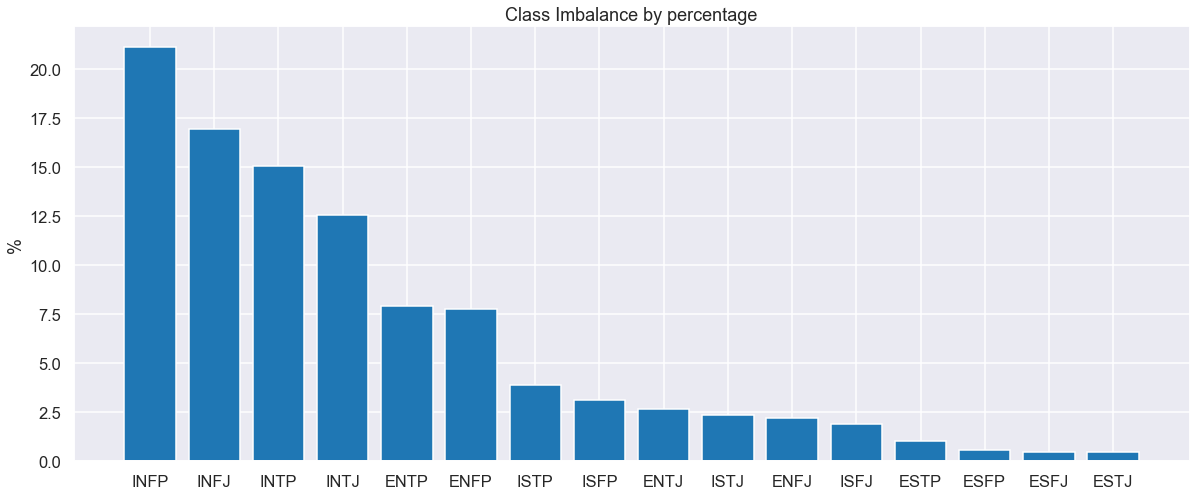

In [7]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [8]:
# looking at 2 some random posts
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can often be quite rude...

>>>>>>>>>>INFP<<<<<<<<<<
-------------------------
'I would say I'm definitely a shy extrovert, either that, or an introvert. In new social situations, I'm usually pretty quiet and reserved, mainly because I'm observing. This usually leads people to...|||We're usually the people asking, Are you ok? when you've had a bad day, even if we don't know you well. We are the people who make the coffee in the break room because we had a few extra minutes....|||I'd say the hardest part about being an N is that most people AREN'T. Feeling left out or judged because I'm crazy. Seeing little connections, or having big ideas, epiphanies, that are really...|||1. What does your introspection involve? Generally, my introspection is a bunch of different thoughts, feelings, or ideas floating around in my head until I can connect the dots, or draw a meaning...|||Hahahahahahaha. Is it possible for you to sit somewhere else? Sally sounds like she has a bit too many personalities. You shouldn't have to walk 

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- There are definitely incorrect spellings of words and acroynms like `lol` & `btw`
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [9]:
cafe_clean = cafe_df.copy()

In [10]:
# Lowercase y variables
cafe_clean['type'] = cafe_clean.type.str.lower()

# Lowercase X varaible onto a new column
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [11]:
def url_remove(post):
    return re.sub(r'http\S+', '', post)

def pipe_remove(post):
    return re.sub(r'[|]', ' ', post)

def punc_remove(post):
    return re.sub(r'[\'_:]', '', post)

def remove_dig_token(post):
    return [post[i] for i in range(len(post)) if post[i].isalpha()]

def remove_stopwords(post):
    sw = stopwords.words('english')
    # sw.extend(mbti_lst)
    return [post[i] for i in range(len(post)) if post[i] not in sw]

regxx = '(intp)|(intj)|(entp)|(entj)|(infj)|(infp)|(enfj)|(enfp)|(istj)|(isfj)|(estj)|(esfj)|(istp)|(isfp)|(estp)|(esfp)'
def replace_mbti(post):
    new = re.sub("r" + regxx, "", post)
    return new

In [12]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(replace_mbti)

In [13]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(pipe_remove)

In [14]:
# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(url_remove)

In [15]:
# This function will remove punctuation (dependent on what is passed in). This has `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(punc_remove)

In [16]:
# This will create a column of cleaned words that have been tokenized.

pattern = r"(?u)\b\w\w+\b" # words with more than 2 letters

tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer

cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize)

In [17]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(remove_dig_token)

In [18]:
# Removing stopwords
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(remove_stopwords)

In [19]:
# Lemmatizing the words
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lemmatize_text)

In [20]:
# Joining the tokens together into one long string
def join_tokens(tokens):
    long_string = ' '.join(tokens)
    return long_string

cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(join_tokens) # Creating new column

In [21]:
cafe_clean

,type,posts,clean_posts,post_tokens,joined_tokens
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"[moment, sportscenter, top, ten, play, prank, ...",moment sportscenter top ten play prank life ch...
1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...
2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear intp, i enjoyed our conversation the ot...","[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...
...,...,...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp just because i always think of cats as...,"[ixfp, always, think, cat, fi, doms, reason, e...",ixfp always think cat fi doms reason especiall...
8671,enfp,'So...if this thread already exists someplace ...,so...if this thread already exists someplace e...,"[thread, already, exists, someplace, else, hec...",thread already exists someplace else heck dele...
8672,intp,'So many questions when i do these things. I ...,so many questions when i do these things. i w...,"[many, question, thing, would, take, purple, p...",many question thing would take purple pill pic...
8673,infp,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...,"[conflicted, right, come, wanting, child, hone...",conflicted right come wanting child honestly m...


The pre-cleaned tokens tally up to 10637645 total words
The cleaned tokens tally up to 5390281 total words
--------------------
Each feature in pre-cleaned has on average 1226.0 words
Each feature in cleaned has on average 621.0 words
--------------------
Each feature in pre-cleaned  has a median of 1278.0 words
Each feature has a median of 647.0 words
--------------------
The minimum post in pre-cleaned  is 4 words
The minimum post in cleaned is 0 words
--------------------
The minimum post in pre-cleaned  is 1881 words
The minimum post in cleaned is 918 words
--------------------


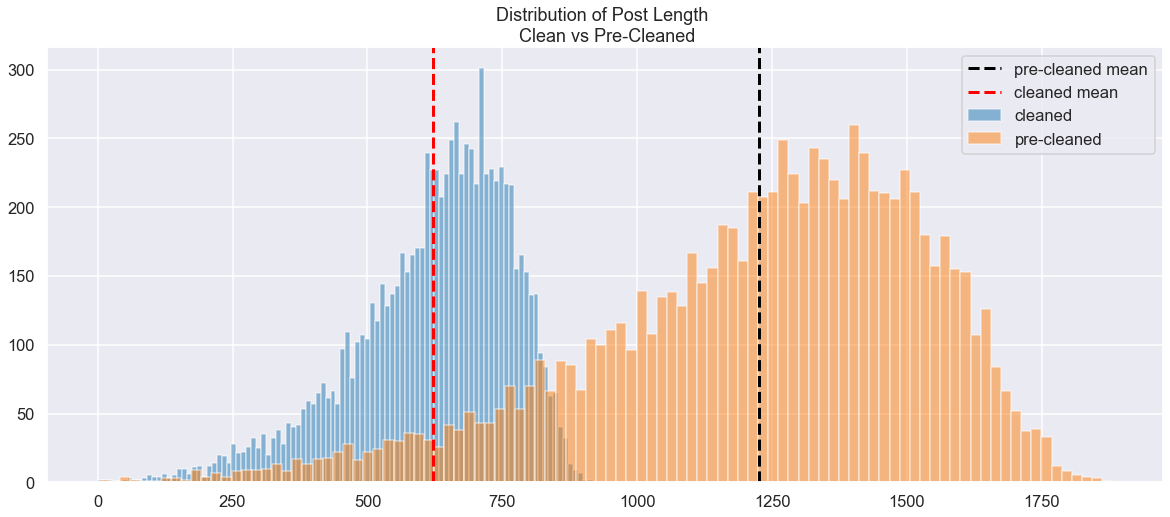

In [22]:
total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean()
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words')

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median()
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min()
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max()
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [23]:
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:1000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:1000])

>>>>>>>>>>ISFP<<<<<<<<<<
-------------------------
'Thank you so much for the mention! But looking back at what i wrote, it now feels so biased and juvenile an attempt.|||I love how you draw and paint. These were just lovely. Beautiful. Especially loved the first two :happy:|||Wow :shocked: I didn't think there'd be so many March people! I am a Marcher too! :tongue:|||Two more that I did today :) Traditional medium. One's edited on Picasa :tongue:  Burning Spring...|||:sad: it's one picture. :'(|||firedell the page shows no picture!|||http://www.youtube.com/watch?v=8uf1n1wUfxE&amp;feature=related|||u200eNothing in the world is permanent, and we’re foolish when we ask anything to last, but surely we’re still more foolish not to take delight in it while we have it. If change is of the essence of...|||I don't know most of the people here (and most of the people don't know me :tongue:) but it was all so cute to read!! Make more matches infps!!! :happy:|||Where does everything go? What are 

#### Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


In [24]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])


In [25]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


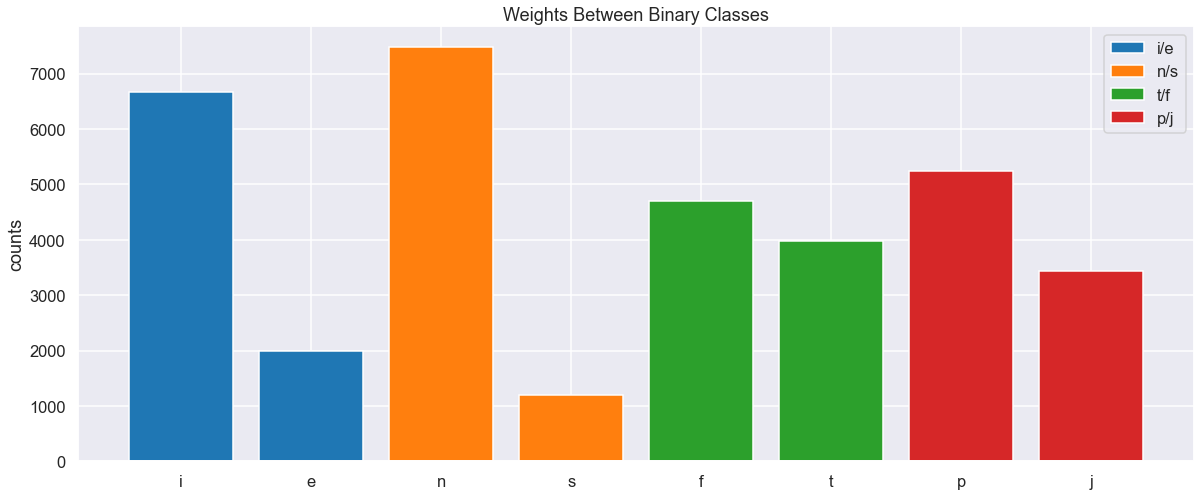

In [26]:
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

## Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [27]:
# Baseline

baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [28]:
for clf in baseline_models:
    print(baseline_models[clf])

SGDClassifier(class_weight='balanced', random_state=53188535)
MultinomialNB()


In [29]:
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

i    0.769568
e    0.230432
Name: i/e, dtype: float64
n    0.862017
s    0.137983
Name: n/s, dtype: float64
f    0.541095
t    0.458905
Name: t/f, dtype: float64
p    0.60415
j    0.39585
Name: p/j, dtype: float64


In [30]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [31]:
rm = run_models()

In [32]:
bin_targets = cafe_clean.columns[-4:]

In [33]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Fri Feb 25 16:32:49 2022
Working on SGDClassifier for i/e @ Fri Feb 25 16:33:01 2022
Working on NaiveBayes for i/e @ Fri Feb 25 16:33:04 2022
--------------------
Vectorizing....  @ Fri Feb 25 16:33:05 2022
Working on SGDClassifier for n/s @ Fri Feb 25 16:33:18 2022
Working on NaiveBayes for n/s @ Fri Feb 25 16:33:19 2022
--------------------
Vectorizing....  @ Fri Feb 25 16:33:19 2022
Working on SGDClassifier for t/f @ Fri Feb 25 16:33:32 2022
Working on NaiveBayes for t/f @ Fri Feb 25 16:33:35 2022
--------------------
Vectorizing....  @ Fri Feb 25 16:33:36 2022
Working on SGDClassifier for p/j @ Fri Feb 25 16:33:48 2022
Working on NaiveBayes for p/j @ Fri Feb 25 16:33:52 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7819,0.7875
1,NaiveBayes_i/e,i/e,0.7704,0.7672
2,SGDClassifier_n/s,n/s,0.8644,0.8585
3,NaiveBayes_n/s,n/s,0.8644,0.8548
4,SGDClassifier_t/f,t/f,0.8086,0.8036
5,NaiveBayes_t/f,t/f,0.5458,0.5284
6,SGDClassifier_p/j,p/j,0.6935,0.6985
7,NaiveBayes_p/j,p/j,0.6101,0.5864


In [34]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Fri Feb 25 16:33:53 2022
Working on SGDClassifier for i/e @ Fri Feb 25 16:34:05 2022
Working on NaiveBayes for i/e @ Fri Feb 25 16:34:09 2022
--------------------
Vectorizing....  @ Fri Feb 25 16:34:09 2022
Working on SGDClassifier for n/s @ Fri Feb 25 16:34:21 2022
Working on NaiveBayes for n/s @ Fri Feb 25 16:34:24 2022
--------------------
Vectorizing....  @ Fri Feb 25 16:34:25 2022
Working on SGDClassifier for t/f @ Fri Feb 25 16:34:38 2022
Working on NaiveBayes for t/f @ Fri Feb 25 16:34:42 2022
--------------------
Vectorizing....  @ Fri Feb 25 16:34:43 2022
Working on SGDClassifier for p/j @ Fri Feb 25 16:34:55 2022
Working on NaiveBayes for p/j @ Fri Feb 25 16:34:59 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7737,0.7658
1,NaiveBayes_i/e,i/e,0.7690,0.7672
2,SGDClassifier_n/s,n/s,0.8457,0.8345
3,NaiveBayes_n/s,n/s,0.8640,0.8548
4,SGDClassifier_t/f,t/f,0.7847,0.7792
5,NaiveBayes_t/f,t/f,0.6997,0.6201
6,SGDClassifier_p/j,p/j,0.6729,0.6676
7,NaiveBayes_p/j,p/j,0.6211,0.5869


In [35]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

(array(['e', 'i'], dtype=object), array([1494, 5012]))
(array(['e', 'i'], dtype=object), array([1494, 1494]))
Vectorizing....  @ Fri Feb 25 16:35:00 2022
Working on SGDClassifier @ Fri Feb 25 16:35:06 2022
Working on NaiveBayes @ Fri Feb 25 16:35:07 2022
(array(['n', 's'], dtype=object), array([5624,  882]))
(array(['n', 's'], dtype=object), array([882, 882]))
Vectorizing....  @ Fri Feb 25 16:35:08 2022
Working on SGDClassifier @ Fri Feb 25 16:35:13 2022
Working on NaiveBayes @ Fri Feb 25 16:35:13 2022
(array(['f', 't'], dtype=object), array([3547, 2959]))
(array(['f', 't'], dtype=object), array([2959, 2959]))
Vectorizing....  @ Fri Feb 25 16:35:13 2022
Working on SGDClassifier @ Fri Feb 25 16:35:25 2022
Working on NaiveBayes @ Fri Feb 25 16:35:28 2022
(array(['j', 'p'], dtype=object), array([2537, 3969]))
(array(['j', 'p'], dtype=object), array([2537, 2537]))
Vectorizing....  @ Fri Feb 25 16:35:28 2022
Working on SGDClassifier @ Fri Feb 25 16:35:38 2022
Working on NaiveBayes @ Fri Feb

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6683,0.6722
1,NaiveBayes_i/e,i/e,0.6787,0.6533
2,SGDClassifier_n/s,n/s,0.6434,0.7169
3,NaiveBayes_n/s,n/s,0.6593,0.6538
4,SGDClassifier_t/f,t/f,0.7817,0.7764
5,NaiveBayes_t/f,t/f,0.7528,0.7497
6,SGDClassifier_p/j,p/j,0.6531,0.6289
7,NaiveBayes_p/j,p/j,0.6569,0.6616


In [36]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

(array(['e', 'i'], dtype=object), array([1494, 5012]))
(array(['e', 'i'], dtype=object), array([1494, 1494]))
Vectorizing....  @ Fri Feb 25 16:35:42 2022
Working on SGDClassifier @ Fri Feb 25 16:35:48 2022
Working on NaiveBayes @ Fri Feb 25 16:35:49 2022
(array(['n', 's'], dtype=object), array([5624,  882]))
(array(['n', 's'], dtype=object), array([882, 882]))
Vectorizing....  @ Fri Feb 25 16:35:50 2022
Working on SGDClassifier @ Fri Feb 25 16:35:54 2022
Working on NaiveBayes @ Fri Feb 25 16:35:55 2022
(array(['f', 't'], dtype=object), array([3547, 2959]))
(array(['f', 't'], dtype=object), array([2959, 2959]))
Vectorizing....  @ Fri Feb 25 16:35:55 2022
Working on SGDClassifier @ Fri Feb 25 16:36:07 2022
Working on NaiveBayes @ Fri Feb 25 16:36:09 2022
(array(['j', 'p'], dtype=object), array([2537, 3969]))
(array(['j', 'p'], dtype=object), array([2537, 2537]))
Vectorizing....  @ Fri Feb 25 16:36:10 2022
Working on SGDClassifier @ Fri Feb 25 16:36:21 2022
Working on NaiveBayes @ Fri Feb

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7138,0.6870
1,NaiveBayes_i/e,i/e,0.6948,0.6482
2,SGDClassifier_n/s,n/s,0.7069,0.7603
3,NaiveBayes_n/s,n/s,0.6893,0.7801
4,SGDClassifier_t/f,t/f,0.8123,0.8054
5,NaiveBayes_t/f,t/f,0.7180,0.7266
6,SGDClassifier_p/j,p/j,0.6928,0.6814
7,NaiveBayes_p/j,p/j,0.6596,0.6473


---

## Model Tuning

In [37]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED))
])

              precision    recall  f1-score   support

           i       0.64      0.26      0.37       458
           e       0.83      0.96      0.89      1711

    accuracy                           0.81      2169
   macro avg       0.74      0.61      0.63      2169
weighted avg       0.79      0.81      0.78      2169

              precision    recall  f1-score   support

           n       0.87      0.99      0.93      1877
           s       0.47      0.03      0.06       292

    accuracy                           0.86      2169
   macro avg       0.67      0.51      0.49      2169
weighted avg       0.82      0.86      0.81      2169

              precision    recall  f1-score   support

           f       0.80      0.86      0.83      1150
           t       0.83      0.75      0.79      1019

    accuracy                           0.81      2169
   macro avg       0.81      0.81      0.81      2169
weighted avg       0.81      0.81      0.81      2169

              preci

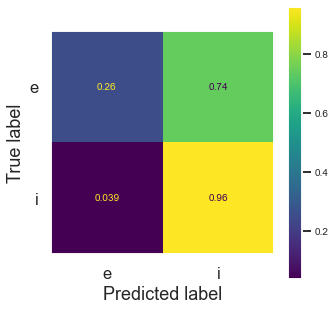

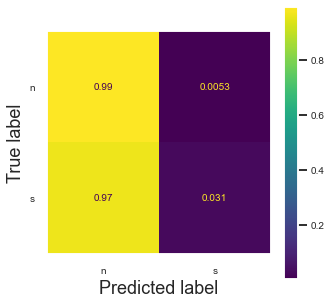

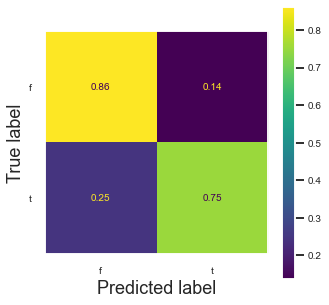

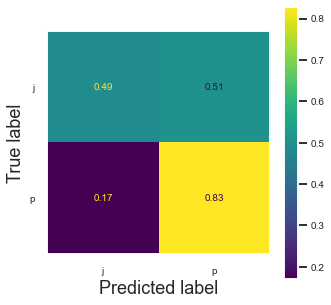

In [38]:
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

---

### i/e

In [39]:
cafe_clean['i/e'].value_counts(normalize=True)

i    0.769568
e    0.230432
Name: i/e, dtype: float64

              precision    recall  f1-score   support

           i       0.47      0.53      0.50       458
           e       0.87      0.84      0.86      1711

    accuracy                           0.78      2169
   macro avg       0.67      0.69      0.68      2169
weighted avg       0.79      0.78      0.78      2169



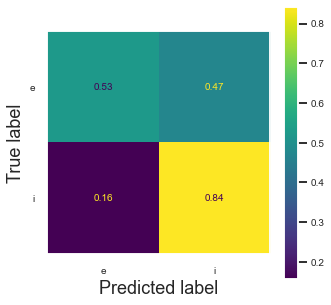

In [40]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'e': .77, 'i': .23}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['i/e'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### n/s

In [41]:
cafe_clean['n/s'].value_counts(normalize=True)

n    0.862017
s    0.137983
Name: n/s, dtype: float64

              precision    recall  f1-score   support

           n       0.93      0.79      0.85      1877
           s       0.31      0.62      0.41       292

    accuracy                           0.76      2169
   macro avg       0.62      0.70      0.63      2169
weighted avg       0.85      0.76      0.79      2169



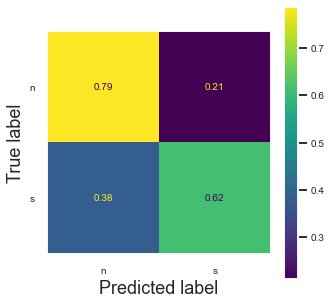

In [42]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .90, 'n': .10}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['n/s']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['n/s'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### t/f

In [43]:
cafe_clean['t/f'].value_counts(normalize=True)

f    0.541095
t    0.458905
Name: t/f, dtype: float64

              precision    recall  f1-score   support

           f       0.80      0.84      0.82      1150
           t       0.81      0.77      0.79      1019

    accuracy                           0.81      2169
   macro avg       0.81      0.81      0.81      2169
weighted avg       0.81      0.81      0.81      2169



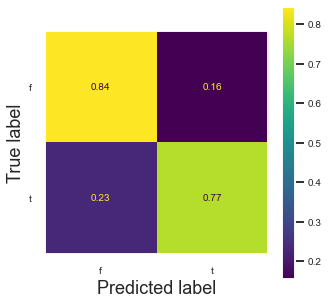

In [44]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### p/j

In [45]:
cafe_clean['p/j'].value_counts(normalize=True)

p    0.60415
j    0.39585
Name: p/j, dtype: float64

              precision    recall  f1-score   support

           j       0.62      0.58      0.60       863
           p       0.73      0.77      0.75      1306

    accuracy                           0.69      2169
   macro avg       0.68      0.67      0.67      2169
weighted avg       0.69      0.69      0.69      2169



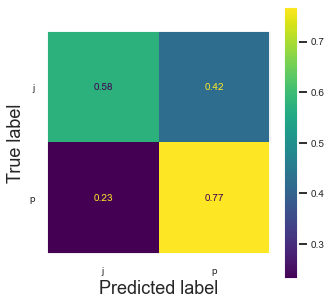

In [46]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'p': .40, 'j': .60}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['p/j']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['p/j'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

## Final Model

              precision    recall  f1-score   support

           f       0.80      0.84      0.82      1150
           t       0.81      0.77      0.79      1019

    accuracy                           0.81      2169
   macro avg       0.81      0.81      0.81      2169
weighted avg       0.81      0.81      0.81      2169



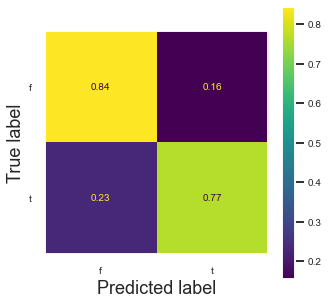

In [47]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

In [56]:
f_test_sample = "I love being in engaging conversation something that doesnt bore me something \
meaningful and makes both of you feel good. But sometimes I get called intense is this just me? \
Like I could say well sometimes you bore me. Seems like Im the minority so its \
really nice when I meet someone my vibe as there arent many"

final_model.predict([f_test_sample])

array(['f'], dtype='<U1')

In [49]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. \
(So there must be some rules without any exception :)"

final_model.predict([t_test_sample])

array(['t'], dtype='<U1')

In [52]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

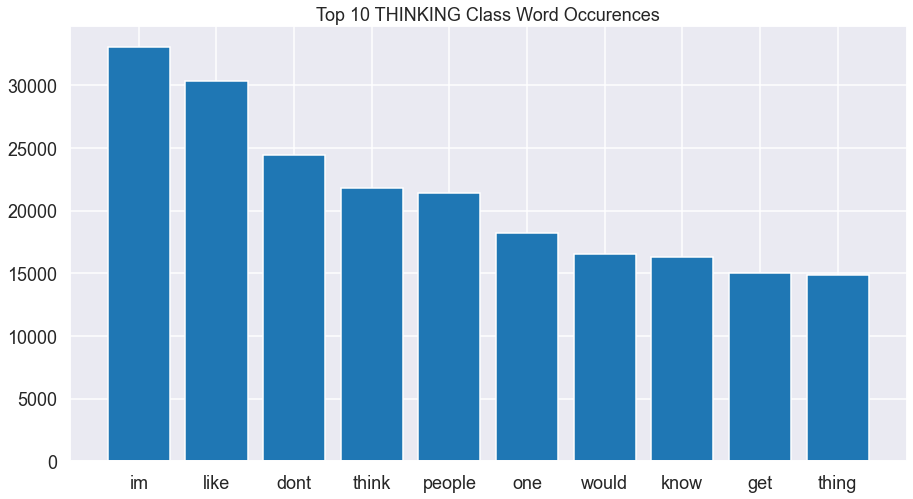

In [53]:
top_ten = list(zip(*t_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 THINKING Class Word Occurences');

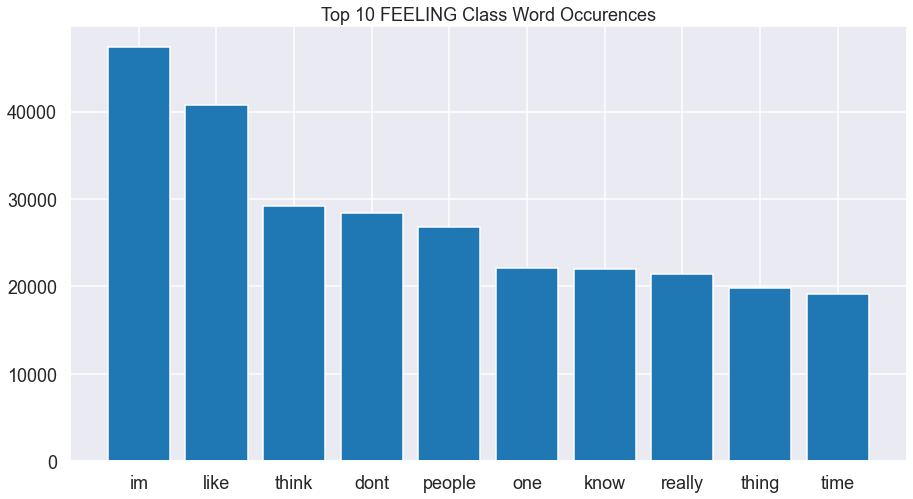

In [54]:
top_ten = list(zip(*f_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 FEELING Class Word Occurences');

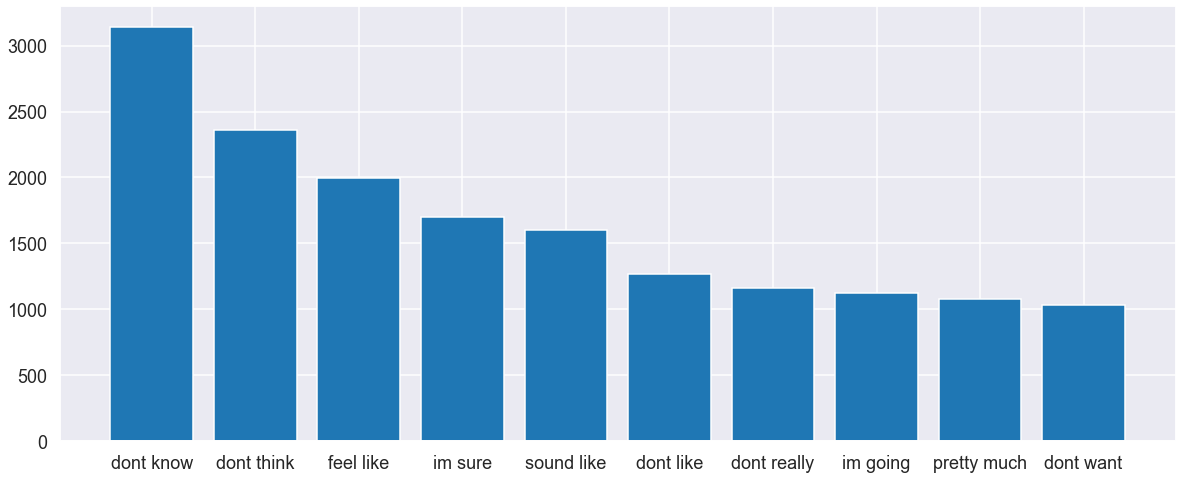

In [58]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

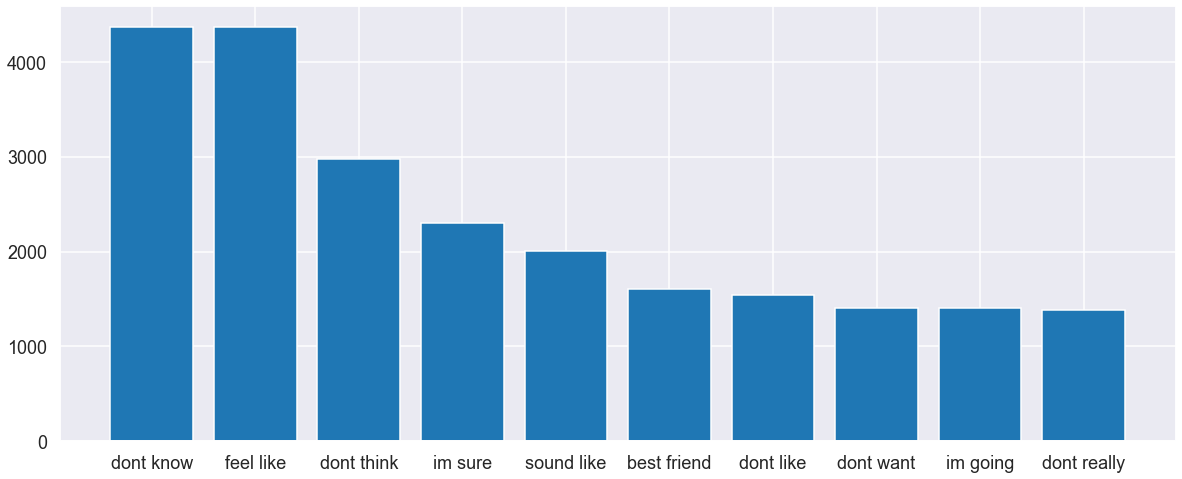

In [57]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:10], df_ngram.frequency.iloc[:10]);

## Thinking vs. Feeling

**Thinking (T)**
When I make a decision, I like to find the basic truth or principle to be applied, regardless of the specific situation involved. I like to analyze pros and cons, and then be consistent and logical in deciding. I try to be impersonal, so I won't let my personal wishes--or other people's wishes--influence me.

The following statements generally apply to me:

- I enjoy technical and scientific fields where logic is important.
- I notice inconsistencies.
- I look for logical explanations or solutions to most everything.
- I make decisions with my head and want to be fair.
- I believe telling the truth is more important than being tactful.
- Sometimes I miss or don't value the "people" part of a situation.
- I can be seen as too task-oriented, uncaring, or indifferent.

**Feeling (F)**
I believe I can make the best decisions by weighing what people care about and the points-of-view of persons involved in a situation. I am concerned with values and what is the best for the people involved. I like to do whatever will establish or maintain harmony. In my relationships, I appear caring, warm, and tactful.

The following statements generally apply to me:

- I have a people or communications orientation.
- I am concerned with harmony and nervous when it is missing.
- I look for what is important to others and express concern for others.
- I make decisions with my heart and want to be compassionate.
- I believe being tactful is more important than telling the "cold" truth.
- Sometimes I miss seeing or communicating the "hard truth" of situations.
- I am sometimes experienced by others as too idealistic, mushy, or indirect.


---

## 500 Set

In [59]:
df_500 = pd.read_csv('./data/MBTI 500.csv')

In [60]:
df_500

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ
...,...,...
106062,stay frustrate world life want take long nap w...,INFP
106063,fizzle around time mention sure mistake thing ...,INFP
106064,schedule modify hey w intp strong wing underst...,INFP
106065,enfj since january busy schedule able spend li...,INFP


In [62]:
df_500['clean_posts'] = df_500['posts'].apply(replace_mbti)

In [63]:
df_500['type'] = df_500['type'].str.lower()

In [68]:
len(df_500)

106067

In [73]:
df_500 = df_500[df_500['clean_posts'].apply(lambda x: len(x.split())) > 450]

The pre-cleaned tokens tally up to 52490846 total words
--------------------
Each feature in pre-cleaned has on average 495.0 words
--------------------
Each feature in pre-cleaned  has a median of 496.0 words
--------------------
The minimum post in pre-cleaned  is 284 words
--------------------
The minimum post in pre-cleaned  is 523 words
--------------------


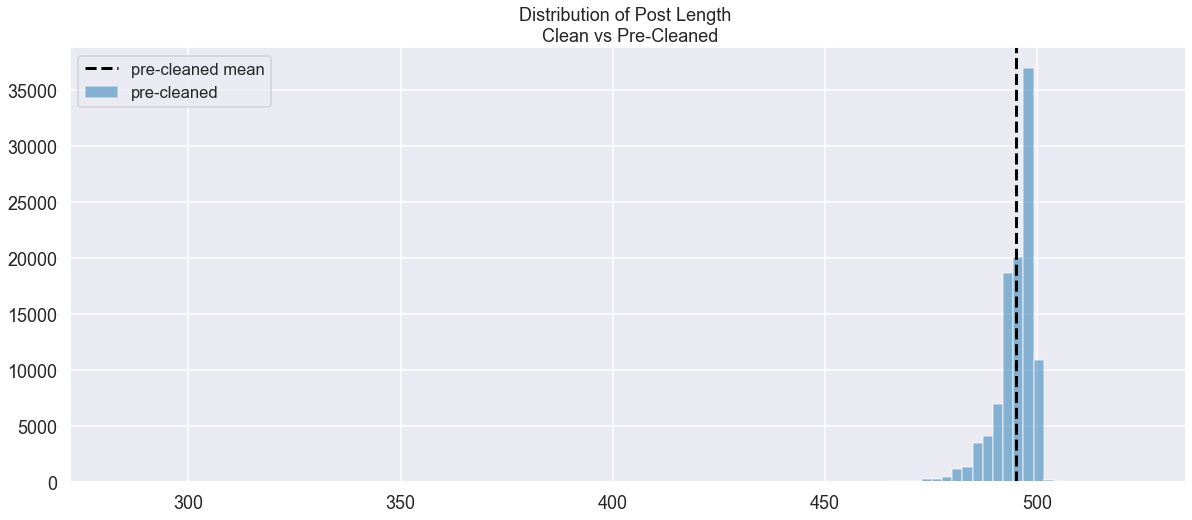

In [74]:
total_words = df_500['clean_posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

print('-'*20)

ave_post = df_500['clean_posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

print('-'*20)

med_post = df_500['clean_posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

print('-'*20)

min_post = df_500['clean_posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

print('-'*20)

max_post = df_500['clean_posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')


print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(df_500['clean_posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [75]:
# Adding Binary Targets
df_500['i/e'] = df_500['type'].map(lambda x: x[0])
df_500['n/s'] = df_500['type'].map(lambda x: x[1])
df_500['t/f'] = df_500['type'].map(lambda x: x[2])
df_500['p/j'] = df_500['type'].map(lambda x: x[3])

In [76]:
print(df_500['i/e'].value_counts(normalize=True))
print(df_500['n/s'].value_counts(normalize=True))
print(df_500['t/f'].value_counts(normalize=True))
print(df_500['p/j'].value_counts(normalize=True))

i    0.760621
e    0.239379
Name: i/e, dtype: float64
n    0.913252
s    0.086748
Name: n/s, dtype: float64
t    0.652443
f    0.347557
Name: t/f, dtype: float64
p    0.581063
j    0.418937
Name: p/j, dtype: float64


In [77]:
# Baseline

baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [78]:
for clf in baseline_models:
    print(baseline_models[clf])

SGDClassifier(class_weight='balanced', random_state=53188535)
MultinomialNB()


In [79]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [80]:
rm = run_models()

In [81]:
bin_targets = cafe_clean.columns[-4:]
bin_targets

Index(['i/e', 'n/s', 't/f', 'p/j'], dtype='object')

In [82]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Fri Feb 25 17:27:15 2022
Working on SGDClassifier for i/e @ Fri Feb 25 17:29:22 2022
Working on NaiveBayes for i/e @ Fri Feb 25 17:29:56 2022
--------------------
Vectorizing....  @ Fri Feb 25 17:30:06 2022
Working on SGDClassifier for n/s @ Fri Feb 25 17:32:19 2022
Working on NaiveBayes for n/s @ Fri Feb 25 17:32:50 2022
--------------------
Vectorizing....  @ Fri Feb 25 17:33:00 2022
Working on SGDClassifier for t/f @ Fri Feb 25 17:35:14 2022
Working on NaiveBayes for t/f @ Fri Feb 25 17:35:37 2022
--------------------
Vectorizing....  @ Fri Feb 25 17:35:47 2022
Working on SGDClassifier for p/j @ Fri Feb 25 17:38:00 2022
Working on NaiveBayes for p/j @ Fri Feb 25 17:38:26 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.8316,0.8405
1,NaiveBayes_i/e,i/e,0.7605,0.7625
2,SGDClassifier_n/s,n/s,0.9276,0.9237
3,NaiveBayes_n/s,n/s,0.9136,0.9124
4,SGDClassifier_t/f,t/f,0.8811,0.8671
5,NaiveBayes_t/f,t/f,0.6532,0.6500
6,SGDClassifier_p/j,p/j,0.7743,0.7672
7,NaiveBayes_p/j,p/j,0.5834,0.5841


In [83]:
rm.run(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Fri Feb 25 17:38:39 2022
Working on SGDClassifier for i/e @ Fri Feb 25 17:40:41 2022
Working on NaiveBayes for i/e @ Fri Feb 25 17:41:34 2022
--------------------
Vectorizing....  @ Fri Feb 25 17:41:47 2022
Working on SGDClassifier for n/s @ Fri Feb 25 17:43:53 2022
Working on NaiveBayes for n/s @ Fri Feb 25 17:44:51 2022
--------------------
Vectorizing....  @ Fri Feb 25 17:45:01 2022
Working on SGDClassifier for t/f @ Fri Feb 25 17:46:56 2022
Working on NaiveBayes for t/f @ Fri Feb 25 17:47:39 2022
--------------------
Vectorizing....  @ Fri Feb 25 17:47:49 2022
Working on SGDClassifier for p/j @ Fri Feb 25 17:49:42 2022
Working on NaiveBayes for p/j @ Fri Feb 25 17:50:32 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.8532,0.8672
1,NaiveBayes_i/e,i/e,0.7816,0.7729
2,SGDClassifier_n/s,n/s,0.9428,0.9428
3,NaiveBayes_n/s,n/s,0.9185,0.9144
4,SGDClassifier_t/f,t/f,0.8968,0.8975
5,NaiveBayes_t/f,t/f,0.8141,0.7638
6,SGDClassifier_p/j,p/j,0.7933,0.8004
7,NaiveBayes_p/j,p/j,0.7185,0.6724


In [84]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

(array(['e', 'i'], dtype=object), array([19081, 60468]))
(array(['e', 'i'], dtype=object), array([19081, 19081]))
Vectorizing....  @ Fri Feb 25 17:50:46 2022
Working on SGDClassifier @ Fri Feb 25 17:51:57 2022
Working on NaiveBayes @ Fri Feb 25 17:52:20 2022
(array(['n', 's'], dtype=object), array([72672,  6877]))
(array(['n', 's'], dtype=object), array([6877, 6877]))
Vectorizing....  @ Fri Feb 25 17:52:25 2022
Working on SGDClassifier @ Fri Feb 25 17:53:04 2022
Working on NaiveBayes @ Fri Feb 25 17:53:10 2022
(array(['f', 't'], dtype=object), array([27584, 51965]))
(array(['f', 't'], dtype=object), array([27584, 27584]))
Vectorizing....  @ Fri Feb 25 17:53:13 2022
Working on SGDClassifier @ Fri Feb 25 17:54:38 2022
Working on NaiveBayes @ Fri Feb 25 17:55:07 2022
(array(['j', 'p'], dtype=object), array([33334, 46215]))
(array(['j', 'p'], dtype=object), array([33334, 33334]))
Vectorizing....  @ Fri Feb 25 17:55:15 2022
Working on SGDClassifier @ Fri Feb 25 17:56:57 2022
Working on Naiv

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.8026,0.7858
1,NaiveBayes_i/e,i/e,0.7705,0.8594
2,SGDClassifier_n/s,n/s,0.8236,0.8498
3,NaiveBayes_n/s,n/s,0.7617,0.9313
4,SGDClassifier_t/f,t/f,0.8835,0.8833
5,NaiveBayes_t/f,t/f,0.8354,0.8085
6,SGDClassifier_p/j,p/j,0.7843,0.7917
7,NaiveBayes_p/j,p/j,0.7777,0.7698


In [85]:
rm.run_usampled(df_500, 'clean_posts', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

(array(['e', 'i'], dtype=object), array([19081, 60468]))
(array(['e', 'i'], dtype=object), array([19081, 19081]))
Vectorizing....  @ Fri Feb 25 17:57:47 2022
Working on SGDClassifier @ Fri Feb 25 17:59:03 2022
Working on NaiveBayes @ Fri Feb 25 17:59:19 2022
(array(['n', 's'], dtype=object), array([72672,  6877]))
(array(['n', 's'], dtype=object), array([6877, 6877]))
Vectorizing....  @ Fri Feb 25 17:59:25 2022
Working on SGDClassifier @ Fri Feb 25 18:00:11 2022
Working on NaiveBayes @ Fri Feb 25 18:00:17 2022
(array(['f', 't'], dtype=object), array([27584, 51965]))
(array(['f', 't'], dtype=object), array([27584, 27584]))
Vectorizing....  @ Fri Feb 25 18:00:19 2022
Working on SGDClassifier @ Fri Feb 25 18:02:01 2022
Working on NaiveBayes @ Fri Feb 25 18:02:18 2022
(array(['j', 'p'], dtype=object), array([33334, 46215]))
(array(['j', 'p'], dtype=object), array([33334, 33334]))
Vectorizing....  @ Fri Feb 25 18:02:25 2022
Working on SGDClassifier @ Fri Feb 25 18:04:19 2022
Working on Naiv

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7994,0.8364
1,NaiveBayes_i/e,i/e,0.7135,0.8518
2,SGDClassifier_n/s,n/s,0.8490,0.8872
3,NaiveBayes_n/s,n/s,0.7262,0.9354
4,SGDClassifier_t/f,t/f,0.8785,0.8622
5,NaiveBayes_t/f,t/f,0.7475,0.6853
6,SGDClassifier_p/j,p/j,0.7776,0.7670
7,NaiveBayes_p/j,p/j,0.7484,0.7261


In [88]:
df_500

,posts,type,clean_posts,i/e,n/s,t/f,p/j
0,know intj tool use interaction people excuse a...,intj,know tool use interaction people excuse antis...,i,n,t,j
1,rap music ehh opp yeah know valid well know fa...,intj,rap music ehh opp yeah know valid well know fa...,i,n,t,j
2,preferably p hd low except wew lad video p min...,intj,preferably p hd low except wew lad video p min...,i,n,t,j
3,drink like wish could drink red wine give head...,intj,drink like wish could drink red wine give head...,i,n,t,j
4,space program ah bad deal meing freelance max ...,intj,space program ah bad deal meing freelance max ...,i,n,t,j
...,...,...,...,...,...,...,...
106062,stay frustrate world life want take long nap w...,infp,stay frustrate world life want take long nap w...,i,n,f,p
106063,fizzle around time mention sure mistake thing ...,infp,fizzle around time mention sure mistake thing ...,i,n,f,p
106064,schedule modify hey w intp strong wing underst...,infp,schedule modify hey w intp strong wing underst...,i,n,f,p
106065,enfj since january busy schedule able spend li...,infp,since january busy schedule able spend little...,i,n,f,p


In [86]:
print(df_500['i/e'].value_counts(normalize=False))
print(df_500['n/s'].value_counts(normalize=False))
print(df_500['t/f'].value_counts(normalize=False))
print(df_500['p/j'].value_counts(normalize=False))

i    80676
e    25390
Name: i/e, dtype: int64
n    96865
s     9201
Name: n/s, dtype: int64
t    69202
f    36864
Name: t/f, dtype: int64
p    61631
j    44435
Name: p/j, dtype: int64


In [87]:
rm.run_usampled(df_500, 'clean_posts', ['type'], baseline_models, models_table, tfidf=True, SEED=234)

(array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([ 1159,  4630,  2228,  8813,   137,   260,   371,  1483, 11196,
        9071, 16843, 18732,   481,   650,   919,  2576]))
(array(['enfj', 'enfp', 'entj', 'entp', 'esfj', 'esfp', 'estj', 'estp',
       'infj', 'infp', 'intj', 'intp', 'isfj', 'isfp', 'istj', 'istp'],
      dtype=object), array([137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137,
       137, 137, 137]))
Vectorizing....  @ Fri Feb 25 18:06:11 2022
Working on SGDClassifier @ Fri Feb 25 18:06:32 2022
Working on NaiveBayes @ Fri Feb 25 18:06:34 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_type,type,0.4991,0.3668
1,NaiveBayes_type,type,0.3755,0.2108


In [91]:
df_500[df_500.clean_posts.str.match(regxx) == True]

,posts,type,clean_posts,i/e,n/s,t/f,p/j
1205,intp democracy work well mostly due failure ed...,intj,intp democracy work well mostly due failure ed...,i,n,t,j
1702,intps work good narrow subject get fact data b...,intj,intps work good narrow subject get fact data b...,i,n,t,j
3260,intp adderall intj anything everything find in...,intj,intp adderall anything everything find intere...,i,n,t,j
3494,intp talk stuff worry often respond care norma...,intj,intp talk stuff worry often respond care norma...,i,n,t,j
4534,intp quite different test say slightly j somet...,intj,intp quite different test say slightly j somet...,i,n,t,j
...,...,...,...,...,...,...,...
103168,intp friend omit like say latch turn part conv...,infp,intp friend omit like say latch turn part conv...,i,n,f,p
103837,intps could show occasionally ek maybe real li...,infp,intps could show occasionally ek maybe real li...,i,n,f,p
103905,intp aimlessness rule intj intps atheism peopl...,infp,intp aimlessness rule intps atheism people di...,i,n,f,p
105166,intp w people steal unethical company full sup...,infp,intp w people steal unethical company full sup...,i,n,f,p


In [ ]:
# final_df = pd.read_pickle('./pickle/finalmodeling_df.pkl')

In [ ]:
# final_df.token_joined.str.match(regxx).sum()

In [ ]:
# final_df['token_joined'] = final_df['token_joined'].apply(replace_mbti)

In [ ]:
# final_df = final_df[final_df.token_joined.str.match(regxx) == False]

In [ ]:
# final_df = final_df.reset_index()

In [ ]:
# final_df

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
# rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
# print(final_df['i/e'].value_counts(normalize=True))
# print(final_df['n/s'].value_counts(normalize=True))
# print(final_df['t/f'].value_counts(normalize=True))
# print(final_df['p/j'].value_counts(normalize=True))

In [ ]:
# rint = np.random.randint(0, len(final_df))

# print(rint)
# print(final_df['type'].iloc[rint])
# final_df['token_joined'].iloc[rint]

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps